## Importing Libraries

In [292]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.stats import poisson


## Loading PCA dataset

In [293]:
pca_data = np.loadtxt("pca_data.txt")

## PCA Implementation


In [294]:
def perform_pca(data):
    mean = np.mean(data, axis=0)
    centered_data = data - mean 
    
    covariance_matrix = np.cov(centered_data, rowvar=False)
    
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    # print("Eigenvalues:" , eigenvalues)
    eigenvalues = eigenvalues[sorted_indices]
    # print("Eigenvalues:" , eigenvalues)
    # print("Eigenvectors:" , eigenvectors)
    eigenvectors = eigenvectors[:, sorted_indices]
    # print("Eigenvectors:" , eigenvectors)
    
    return eigenvalues, eigenvectors, centered_data

eigenvalues, eigenvectors, centered_data = perform_pca(pca_data)

# print("Eigenvalues:" , eigenvalues)
# print("Eigenvectors:" , eigenvectors)
# print("Centered data:" , centered_data)

## Projecting data onto the first two principal components


In [295]:
projected_data = np.dot(centered_data, eigenvectors[:, :2])

## Scatter plot of PCA


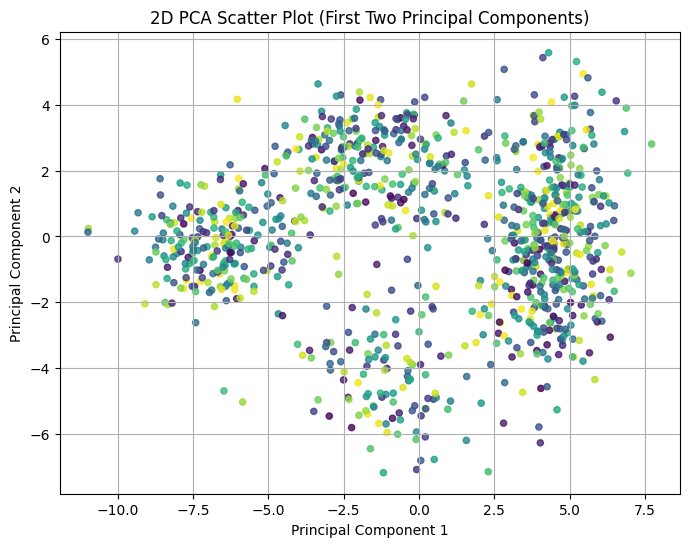

In [296]:
plt.figure(figsize=(8, 6))
colors = np.random.rand(projected_data.shape[0])
plt.scatter(projected_data[:, 0], projected_data[:, 1], s=20, alpha=0.8, c=colors, cmap='viridis')
plt.title("2D PCA Scatter Plot (First Two Principal Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.savefig("pca_scatter_plot.png")
plt.show()

## UMAP Visualization


/Users/md.raihansobhan/myenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


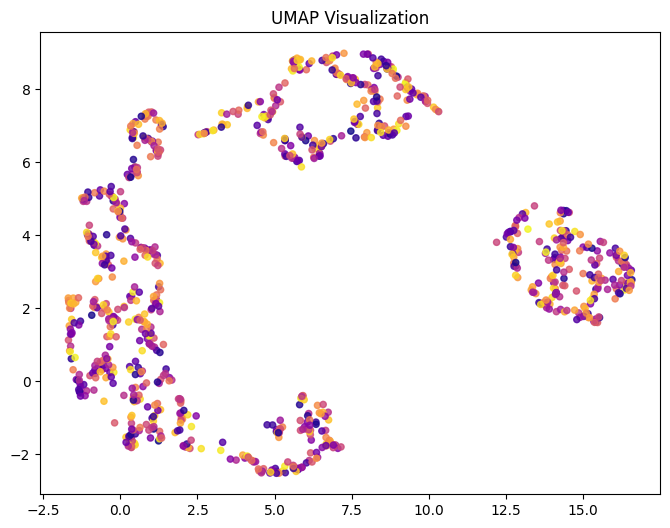

In [297]:
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embedding = umap.fit_transform(pca_data)

plt.figure(figsize=(8, 6))
colors = np.random.rand(umap_embedding.shape[0])  
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=20, alpha=0.8, c=colors, cmap='plasma')
plt.title("UMAP Visualization")
plt.savefig("umap_plot.png")
plt.show()

## t-SNE Visualization

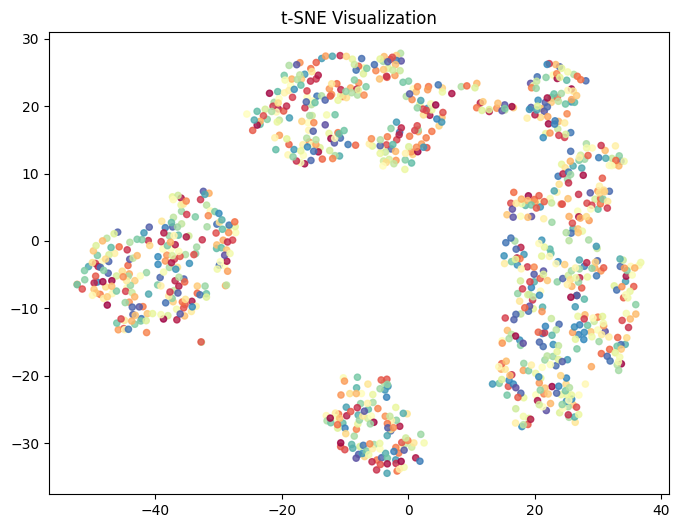

In [298]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embedding = tsne.fit_transform(pca_data)

plt.figure(figsize=(8, 6))
colors = np.random.rand(tsne_embedding.shape[0])
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=20, alpha=0.8, c=colors, cmap='Spectral')
plt.title("t-SNE Visualization")
plt.savefig("tsne_plot.png")
plt.show()

## Loading EM dataset


In [299]:
em_data = np.loadtxt("em_data.txt")
# em_data.shape

## EM Algorithm for Poisson Mixture Model


In [300]:
def em_algorithm(data, max_iter=1000, tol=1e-6):
    n = len(data)
    
    pi = 0.5  
    lambda_1 = np.mean(data) * 0.75 
    lambda_2 = np.mean(data) * 1.25 
    # pi = np.random.rand()
    # lambda_1 = np.random.uniform(np.min(data), np.mean(data))
    # lambda_2 = np.random.uniform(np.mean(data), np.max(data))

    
    
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # E-step
        p1 = pi * poisson.pmf(data, lambda_1)
        p2 = (1 - pi) * poisson.pmf(data, lambda_2)
        total = p1 + p2
        gamma = p1 / total 
        
        # M-step
        pi_new = np.mean(gamma)
        lambda_1_new = np.sum(gamma * data) / np.sum(gamma)
        lambda_2_new = np.sum((1 - gamma) * data) / np.sum(1 - gamma)
        
        log_likelihood = np.sum(np.log(total))
        log_likelihoods.append(log_likelihood)
        
        if iteration > 0 and np.abs(log_likelihood - log_likelihoods[-2]) < tol:
            break
        
        pi, lambda_1, lambda_2 = pi_new, lambda_1_new, lambda_2_new
    
    return pi, lambda_1, lambda_2, log_likelihoods

pi, lambda_1, lambda_2, log_likelihoods = em_algorithm(em_data)

## Results


In [301]:
print("EM Algorithm Results:")
print(f"Proportion of families with family planning: {pi:.4f}")
print(f"Proportion of families without family planning: {1 - pi:.4f}")
print(f"Mean number of children (with family planning): {lambda_1:.4f}")
print(f"Mean number of children (without family planning): {lambda_2:.4f}")

EM Algorithm Results:
Proportion of families with family planning: 0.3562
Proportion of families without family planning: 0.6438
Mean number of children (with family planning): 1.7831
Mean number of children (without family planning): 4.9113


## Log likelihoods


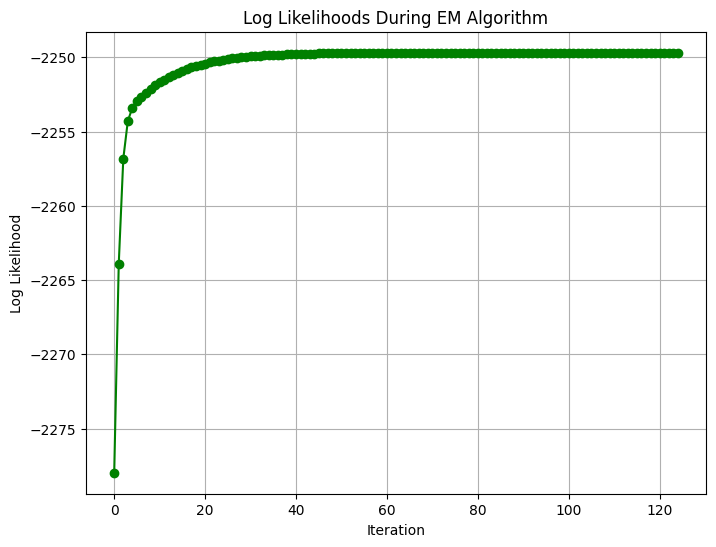

In [302]:
plt.figure(figsize=(8, 6))
plt.plot(log_likelihoods, marker='o', linestyle='-', c='g')
plt.title("Log Likelihoods During EM Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.savefig("em_log_likelihoods.png")
plt.show()


## Frequency histogram and estimated distributions


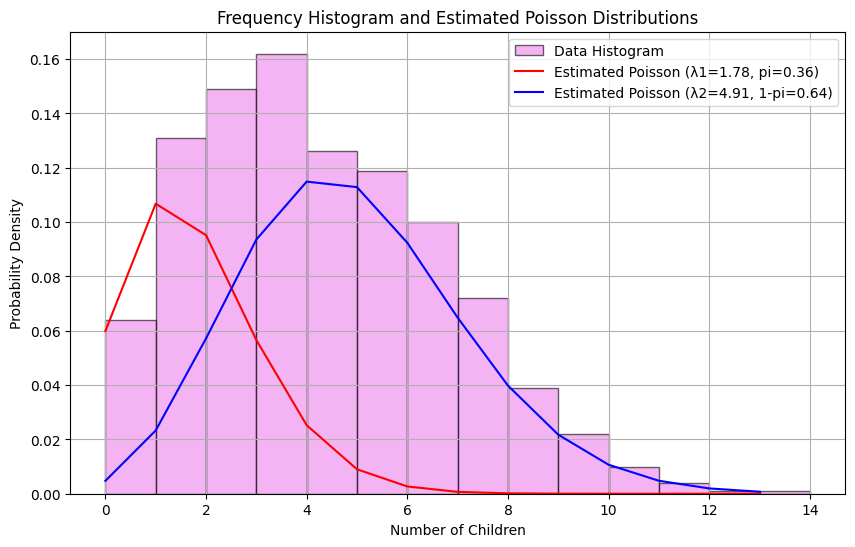

In [303]:
def plot_histogram_with_estimated_distributions(data, lambda_1, lambda_2, pi):
    bins = range(0, int(max(data)) + 2)  
    plt.figure(figsize=(10, 6))
    
    plt.hist(data, bins=bins, density=True, alpha=0.6, color='violet', edgecolor='black', label='Data Histogram')
    
    x = np.arange(0, int(max(data)) + 1) 
    poisson_1 = poisson.pmf(x, lambda_1) * pi
    poisson_2 = poisson.pmf(x, lambda_2) * (1 - pi)
    
    plt.plot(x, poisson_1, 'r-', label=f'Estimated Poisson (λ1={lambda_1:.2f}, pi={pi:.2f})')
    plt.plot(x, poisson_2, 'b-', label=f'Estimated Poisson (λ2={lambda_2:.2f}, 1-pi={1-pi:.2f})')
    
    plt.title("Frequency Histogram and Estimated Poisson Distributions")
    plt.xlabel("Number of Children")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.savefig("em_histogram_with_estimation.png")
    plt.show()

plot_histogram_with_estimated_distributions(em_data, lambda_1, lambda_2, pi)
